# Projet de gestion des risques multiples : application de la théorie des copules

Mariane ALAPINI & Céleste NENEHIDINI

In [5]:
# Importation des bibliothèques
import pandas as pd 
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

## 1. Extraction des probabilités de défaut implicites
Au moyen d’une CreditVaR à 99 %, on cherche à évaluer le risque de crédit sur un portefeuille composé de deux créances, issues du secteur bancaire, de même notionnel 1000 EUR et de même maturité 4 ans.
La première est une obligation BNP senior de taux de recouvrement de moyenne 60% et de volatilité 15%, et la seconde est une obligation Société Générale junior (ou subordonnée) de taux de recouvrement de moyenne 30% et de volatilité 25%. On suppose qu’il n’y a pas de dépendance entre les taux de recouvrement.

On considère que les spreads de CDS de BNP et SG de maturité 4ans sont respectivement 100bp et 120bp et ceux de maturité 5ans, 120bp et 150bp. Les CDS ont été évalués avec un taux de recouvrement égal à 40%. 

Pour extraire les probabilités de défauts, nous allons utiliser les CDS étant plus liquides que les obligations. Les CDS sont des contrats d'assurance contre le défaut d'une entreprise. Le spread de CDS est le prix de cette assurance. Plus le spread est élevé, plus le marché estime que l'entreprise est risquée. Le spread est donnée par :

$$
s* = (1-\delta) \times \lambda
$$

Avec $\delta$ le taux de recouvrement et $\lambda$ le hazard rate. Le hazard rate est la probabilité de défaut de l'entreprise. On peut donc isoler le hazard rate :

$$
\lambda = \frac{s*}{1-\delta}
$$

De ce fait, on peut calculer la probabilité de défaut donnée par :
$$
PD = P(\tau < T) = 1 - e^{-\lambda \times T}
$$

car $\tau \sim Exp(\lambda)$

In [2]:
# Paramètres
recovery = 0.4

# On crée un dictionnaire pour stocker les spreads en basis points pour les deux maturités
spreads_bp = {'BNP': {4: 100, 5: 120}, 'SG': {4: 120, 5: 150}}

# Calcul des probabilités de défaut à partir des spreads
for name, mats in spreads_bp.items():
    for T, bp in mats.items():
        s = bp / 10000  # on fait la conversion en décimal des bp
        lamda = s / (1 - recovery)
        pd = 1 - np.exp(-lamda * T)
        print(f"{name} {T} ans : spread={bp} bp, lambda={lamda:.6f}, PD={pd:.4%}")

BNP 4 ans : spread=100 bp, lambda=0.016667, PD=6.4493%
BNP 5 ans : spread=120 bp, lambda=0.020000, PD=9.5163%
SG 4 ans : spread=120 bp, lambda=0.020000, PD=7.6884%
SG 5 ans : spread=150 bp, lambda=0.025000, PD=11.7503%


**Conclusion** : 

On remarque principalement que les probabilités de défaut de la SG sont plus élevées que celles de la BNP, quel que soit la maturité considérée. Ceci peut s'expliquer par le fait que les obligations senior sont plus solides que les juniors. 

## 2. Caractérisation des distributions des taux de recouvrement de chacune des deux créances

Pour caractériser les distributions des taux de recouvrement, on peut utiliser la loi Beta (a,b). La loi Beta est une loi de probabilité continue définie sur l'intervalle [0, 1]. Elle est souvent utilisée pour modéliser des variables aléatoires qui prennent des valeurs dans un intervalle borné en forme de U ce qui est le cas des taux de recouvrement. 

Pour une loi $\mathrm{Beta}(a,b)$, on a :
$$
\mathbb{E}[X] = \mu = \frac{a}{a+b}, 
\qquad
\mathrm{Var}(X) = \sigma^2 = \frac{\mu(1-\mu)}{a+b+1}.
$$

On en déduit :
$$
a + b = \frac{\mu(1-\mu)}{\sigma^2} - 1.
$$

L'expression de sa densité est donnée par :

$$
f(x) = \frac{x^{a-1} \times (1-x)^{b-1}}{B(a,b)} 1_{[0,1]}(x)
$$

Puisque nous possédons des taux de recouvrement de moyenne 60% et de volatilité 15% pour la première créance et de moyenne 30% et de volatilité 25% pour la seconde créance, nous allons utiliser la méthode des moments pour déterminer les paramètres a et b de la loi Beta. De ce fait, les paramètres sont calibrés de la manière suivante :

$$
a = \mu\left(\frac{\mu(1-\mu)}{\sigma^2} - 1\right),
\qquad
b = (1-\mu)\left(\frac{\mu(1-\mu)}{\sigma^2} - 1\right).
$$

### 2.1. Caractérisation de la distribution des taux de recouvrement BNP
L'obligation BNP senior est de taux de recouvrement de moyenne 60% et de volatilité 15%

Paramètres de la loi Beta pour BNP : a=5.8000, b=3.8667


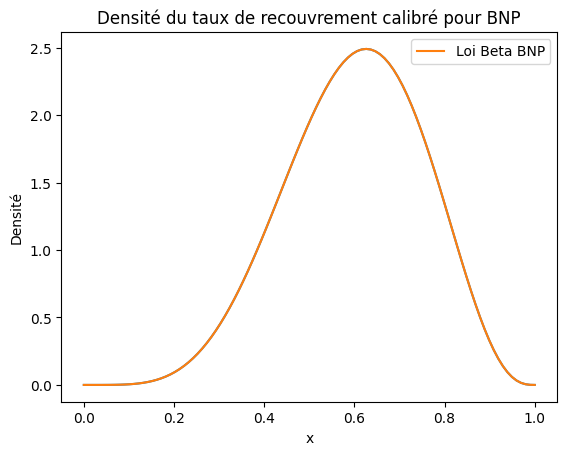

In [8]:
# Paramètres de la distribution BNP
mu_bnp = 0.6
sigma_bnp = 0.15

# Fonction de calibration de la distribution beta par la méthode des moments
def calibration_loi_beta(mu, sigma):
    k = (mu * (1 - mu) / (sigma**2)) - 1
    a = mu * k
    b = (1 - mu) * k
    return a, b

# Calibration de la loi beta pour BNP
a_bnp, b_bnp = calibration_loi_beta(mu_bnp, sigma_bnp)
print(f"Paramètres de la loi Beta pour BNP : a={a_bnp:.4f}, b={b_bnp:.4f}")

# Représentation de la densité de la loi beta calibrée
x = np.linspace(0,1,100)
y_BNP = beta.pdf(x, a_bnp, b_bnp)
plt.plot(x,y_BNP)
plt.plot(x, y_BNP, label='Loi Beta BNP')
plt.title('Densité du taux de recouvrement calibré pour BNP')
plt.xlabel('x')
plt.ylabel('Densité')
plt.legend()
plt.show()

On remarque que la distribution des taux de recouvrement pour la BNP est asymétrique à droite. Cette remarque est assez normale car le paramètre **a** qui contrôle la concentration des valeurs proches de 1, est plus élevé que le paramètre **b** qui contôle lui la concentration des valeurs proches de 0. On peut donc conclure qu'il y a une très faible probabilité de recouvrement très bas, et de recouvrement total aussi. En faisant le parallèle avec la LGD, on peut dire qu'il y a de très faibles probabilités pour que la perte soit très élevées en général. 

### 2.2. Caractérisation de la distribution des taux de recouvrement SG
L'obligation Société Générale junior (ou subordonnée) est de taux de recouvrement de moyenne 30% et de volatilité 25%.

Paramètres de la loi Beta pour SG : a=0.7080, b=1.6520


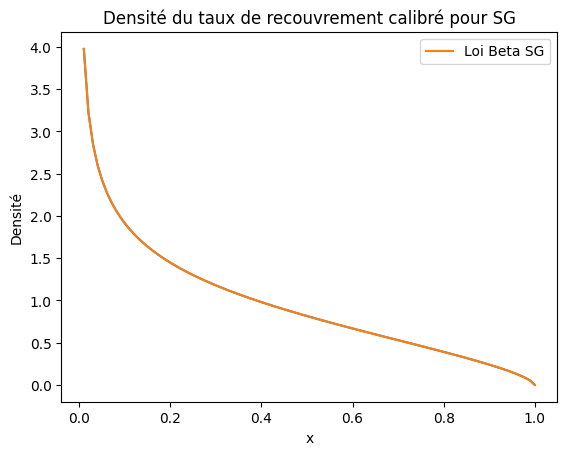

In [9]:
# Paramètres de la distribution SG
mu_sg = 0.3
sigma_sg = 0.25

# Calibration de la loi beta pour SG
a_sg, b_sg = calibration_loi_beta(mu_sg, sigma_sg)
print(f"Paramètres de la loi Beta pour SG : a={a_sg:.4f}, b={b_sg:.4f}")

# Représentation de la densité de la loi beta calibrée
x = np.linspace(0,1,100)
y_SG = beta.pdf(x, a_sg, b_sg)
plt.plot(x,y_SG)
plt.plot(x, y_SG, label='Loi Beta SG')
plt.title('Densité du taux de recouvrement calibré pour SG')
plt.xlabel('x')
plt.ylabel('Densité')
plt.legend()
plt.show()

La densité estimée du taux de recouvrement pour l'obligation junior SG présente une forte asymétrie à gauche, avec une concentration pour des valeurs proches de zéro. Cela signifie que, dans la majorité des scénarios de défaut, les montants effectivement récupérés sont faibles. La densité décroît ensuite de manière continue, ce qui indique que les taux de recouvrement plus élevés deviennent progressivement moins probables, bien qu’ils ne soient pas exclus.

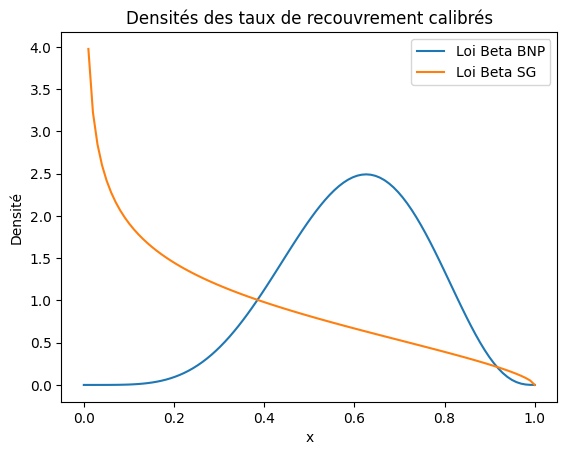

In [10]:
# Représenter les deux densités sur le même graphique
plt.plot(x, y_BNP, label='Loi Beta BNP')
plt.plot(x, y_SG, label='Loi Beta SG')
plt.title('Densités des taux de recouvrement calibrés')
plt.xlabel('x')
plt.ylabel('Densité')
plt.legend()
plt.show()

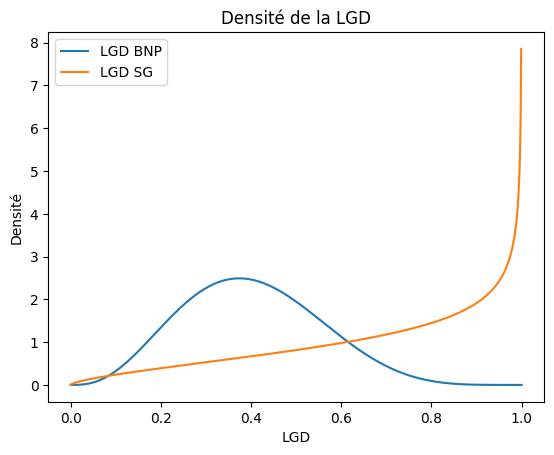

In [12]:
# Comparaison des densités de LGD pour BNP et SG
x = np.linspace(0, 1, 1000)

# densités LGD
lgd_bnp_pdf = beta.pdf(x, b_bnp, a_bnp)
lgd_sg_pdf = beta.pdf(x, b_sg, a_sg)

plt.plot(x, lgd_bnp_pdf, label="LGD BNP")
plt.plot(x, lgd_sg_pdf, label="LGD SG")
plt.xlabel("LGD")
plt.ylabel("Densité")
plt.title("Densité de la LGD")
plt.legend()
plt.show()
